# Gray Swan Alarming 
### by --- Jiang Xing

In [1]:
import pandas as pd
import numpy as np
import datetime
import calendar
import matplotlib.pyplot as plt

import jqdata
from jqdata import *
from jqfactor import get_factor_values

### Stock Base Selection
##### Period：2010-01-01至2019-10-31
##### Extra Stock Selection Rules：
* Exclude ST on the selecting day
* Exclude IPO within one year
* Exclude suspended stocks on the selecting day

In [2]:
def get_base_stocks(date, rm_ipo_in_1y=True): 
    s = get_all_securities(types=['stock'], date=date)
    if(rm_ipo_in_1y==True):
        # Exclude IPO within one year
        s['current_dt'] = datetime.datetime.strptime(date, '%Y-%m-%d')
        s['start_date'] = s['start_date'].map(lambda x: datetime.datetime.strptime(str(x), '%Y-%m-%d'))
        s['days'] = s['current_dt'] - s['start_date']
        s = s[s['days']>'370days']
    new_s = list(s.index)    
    return new_s

def rmv_suspend(stocks, end_date):   
    # Exclude suspended stocks on the selecting day
    s = get_price(stocks,end_date=end_date,count=1,fields='paused').paused.sum()
    new_s = s[s< 1].index.tolist()
    return new_s

def st(stocks, date):
    # Exclude ST on the selecting day(the nearest trading day)
    date = get_trade_days(end_date=date, count=1)[0].strftime('%Y-%m-%d')
    s = get_extras('is_st', stocks, start_date=date, end_date=date, df=True).T
    s.columns = ['is_st']
    new_s = list(s[s['is_st']==False].index)
    return new_s

In [3]:
def get_stock_base(date_I):
    stocks = get_base_stocks(date_I, rm_ipo_in_1y=True)
    #stocks = rmv_suspend(stocks, end_date=date_I)
    stocks = st(stocks, date_I)
    return stocks

### Factors Selection

In [65]:
# valuation.code,valuation.pb_ratio, valuation.pe_ratio, valuation.market_cap, indicator.eps, indicator.roe, 
# indicator.roa, indicator.inc_net_profit_year_on_year, indicator.inc_net_profit_annual, 
# indicator.inc_total_revenue_year_on_year, indicator.inc_total_revenue_annual

factors = [valuation.code,valuation.pe_ratio, 
           valuation.market_cap,  
           indicator.inc_net_profit_annual]


In [66]:
def get_factors(stocks, factors, date):
    factors_data = get_fundamentals(
        query(*factors)
        .filter(valuation.code.in_(stocks)), 
        date=date)
    factors_data['time'] = date
    return factors_data

5. 情绪因子
   * DAVOL10	10日平均换手率与120日平均换手率之比
   * VSTD20	20日成交量标准差
   * TVSTD20  20日成交金额的标准差
   * VOL20	20日平均换手率
   * turnover_volatility	换手率相对波动率
   * VOSC	成交量震荡	'VEMA12'和'VEMA26'两者的差值，再求差值与'VEMA12'的比，最后将比值放大100倍，得到VOSC值
6. 风险因子
   * Variance20	20日年化收益方差
   * sharpe_ratio_20	20日夏普比率
   * sharpe_ratio_60	60日夏普比率
   * Skewness20	个股收益的20日偏度 https://blog.csdn.net/roll_jj/article/details/85259223
   * Kurtosis20	个股收益的20日峰度
7. 动量因子
   * Volume1M	当前交易量相比过去1个月日均交易量 与过去过去20日日均收益率乘积	当日交易量 / 过去20日交易量MEAN * 过去20日收益率MEAN
   * BIAS10	10日乖离率  https://baike.baidu.com/item/%E4%B9%96%E7%A6%BB%E7%8E%87/420286?fr=aladdin
   * arron_up_25	Aroon指标上轨
   * arron_down_25	Aroon指标下轨
   * BBIC	BBI 动量
   * bear_power	空头力道
   * bull_power	多头力道
   * CR20	CR指标
8. 技术因子
   * boll_down	下轨线（布林线）指标
   * boll_up	上轨线（布林线）指标
   * EMA5	5日指数移动均线
   * EMAC20	20日指数移动均线
   * MAC5	5日移动均线
   * MAC20	20日移动均线
   * MACDC	平滑异同移动平均线
   * MFI14	资金流量指标
9. 风格因子
   * beta	贝塔  表征股票相对于市场的波动敏感度
   * momentum	动量	描述了过去两年里相对强势的股票与弱势股票之间的差异
   * liquidity	流动性	解释了由股票相对的交易活跃度不同而产生的收益率差异
   

In [67]:
'''
# Available Factors:
'DAVOL10','VSTD20','TVSTD20','VOL20','turnover_volatility',
'VOSC','Variance20','sharpe_ratio_20','sharpe_ratio_60',
'Skewness20','Kurtosis20','Volume1M','BIAS10',
'arron_up_25','arron_down_25','BBIC','bear_power',
'bull_power','CR20','boll_down','boll_up',
'EMA5','EMAC20','MAC5','MAC20','MACDC','MFI14',
'beta','momentum','liquidity','roa_ttm','roe_ttm'
'''

other_factors = ['VSTD20','TVSTD20',
                 'sharpe_ratio_20',
                 'Skewness20','Kurtosis20',
                 'arron_down_25','MAC20',
                 'beta','roa_ttm','roe_ttm']

In [68]:
def get_other_factors(stocks, other_factors, date):
    factor_data = get_factor_values(securities=stocks, 
                                    factors=other_factors, 
                                    end_date=date, count=1)
    data = pd.DataFrame()
    data['code'] = stocks
    for i in other_factors:
        tem = factor_data[i]
        tem = tem.reset_index()[stocks].T.reset_index()
        tem.columns=['code', i]
        data = data.merge(tem, how='left', on='code')
    data['time'] = date
    return data
        

In [24]:
get_other_factors(['000001.XSHE','000002.XSHE'], other_factors, '2019-01-01')

,code,DAVOL10,VSTD20,TVSTD20,TVMA20,turnover_volatility,time
0,000001.XSHE,0.654384,179497.204336,2.124449e+08,5.987081e+08,0.001228,2019-01-01
1,000002.XSHE,0.791047,94471.421333,3.256182e+08,1.015868e+09,0.001289,2019-01-01


##### merge factors data together

In [69]:
def get_all_1_mon_factors(stocks, factors, other_factors, date):
    factors_1 = get_factors(stocks, factors, date)
    factors_2 = get_other_factors(stocks, other_factors, date)
    factors_data = factors_1[factors_1.columns[:-1]].merge(factors_2, how='left', on='code')
    factors_data = factors_data.fillna(0.0)
    #all_factors = factors_data.columns[1:-1]
    return factors_data#, all_factors

In [26]:
a= get_all_1_mon_factors(['000001.XSHE','000002.XSHE'], factors, other_factors, '2019-08-31')
a

,code,pb_ratio,pe_ratio,market_cap,inc_net_profit_year_on_year,inc_net_profit_annual,inc_total_revenue_year_on_year,inc_total_revenue_annual,DAVOL10,VSTD20,TVSTD20,TVMA20,turnover_volatility,time
0,000001.XSHE,1.0438,9.0556,2431.3301,17.41,6.86,21.01,8.86,1.374616,518160.302987,9.258274e+08,2.061893e+09,0.003583,2019-08-31
1,000002.XSHE,1.8110,7.9910,2915.9529,36.93,401.56,21.02,88.00,0.950050,70421.801183,2.545904e+08,1.056312e+09,0.001003,2019-08-31


##### get 12 month's factor data for rnn models

In [70]:
def gen_array_data(df, num_of_factors):
    codes = sorted(list(set(np.array(df['code']))))
    data = np.zeros((len(codes), 12, num_of_factors))
    for i,c in enumerate(codes):
        temp = np.array(df[df['code']==str(c)])[:,1:-1]
        if temp.shape != (12, num_of_factors):
            print(i, c)
            continue
        data[i] = temp
    return data

def get_12mon_factors(stocks, factors, other_factors, date):
    cols = get_all_1_mon_factors([stocks[0]], factors, other_factors, date).columns
    factors_12mon = pd.DataFrame(columns=cols)
    dates = list(pd.date_range(end=date, periods=12, freq='M').strftime('%Y-%m-%d'))
    for dt in dates:
        tem = get_all_1_mon_factors(stocks, factors, other_factors, dt)
        factors_12mon = factors_12mon.append(tem, ignore_index=True)
    factors_12mon.sort_values(by=['code','time'])
    factors_12mon = factors_12mon.fillna(0.0)
    factors_12mon = gen_array_data(factors_12mon, len(factors)-1+len(other_factors))
    return factors_12mon

In [28]:
get_12mon_factors(['000001.XSHE','000002.XSHE'], factors, other_factors, '2019-09-30')

array([[[0.8702, 7.6486, 1873.2919, 7.35, 4.53, 14.21, 0.71, 1.621206,
         376436.227959, 493808514.984, 1644117060.54, 0.002576],
        [0.8263, 7.263, 1778.8546, 7.35, 4.53, 14.21, 0.71, 0.682147,
         263647.007391, 335864224.491, 904621818.827, 0.001804],
        [0.7481, 6.5760000000000005, 1610.5846, 7.35, 4.53, 14.21, 0.71,
         0.654384, 179497.204336, 212444898.35, 598708110.049, 0.001228],
        [0.866, 7.6796, 1905.9156, 7.35, 4.53, 14.21, 0.71, 0.879235,
         340761.742518, 426790331.448, 893843882.565, 0.002332],
        [0.9643, 8.5513, 2122.2627, 7.35, 4.53, 14.21, 0.71, 1.418541,
         477692.871073, 697523746.148, 1418046075.56, 0.003269],
        [1.0002, 8.8696, 2201.2466, 8.08, -38.42, 15.79, 2.14, 0.976661,
         365115.269297, 561943404.648, 1575408192.97, 0.002498],
        [1.0464, 9.2645, 2378.1021, 12.9, 70.7, 15.88, 8.07, 1.112469,
         420212.182983, 708187035.447, 1680859799.95, 0.002875],
        [0.9202, 8.1474, 2091.3562, 1

### Monthly yield_rates calculation

In [71]:
def get_yield_rates(stocks, date_I, date_II):
    # get yield rates for each stock in the pool
    price_II = get_price(stocks, 
                      start_date=date_II[:8]+'01', end_date=date_II, frequency='daily', 
                      fields=['close'], skip_paused=False, fq='post', 
                      count=None, panel=False)
    price_II['year'] = price_II['time'].dt.year
    price_II['mon'] = price_II['time'].dt.month
    
    price_I = get_price(stocks, 
                      start_date=date_I[:8]+'01', end_date=date_I, frequency='daily', 
                      fields=['close'], skip_paused=False, fq='post', 
                      count=None, panel=False)
    price_I['year'] = price_I['time'].dt.year
    price_I['mon'] = price_I['time'].dt.month
    
    # keep only the last trading day per mon
    price_II = price_II.drop_duplicates(subset=['code','year','mon'], 
                                        keep='last', inplace=False)
    price_II = price_II[['time','code','close']]
    price_I = price_I.drop_duplicates(subset=['code','year','mon'], 
                                      keep='last', inplace=False)
    price_I = price_I[['time','code','close']]
    
    price_I['last'] = list(price_II['close'])
    price_I['yield_rate'] = (price_I['close']-price_I['last'])/price_I['last']
    stock_pool = price_I[['code', 'yield_rate']]
    return stock_pool

In [72]:
def get_12mon_yield_rates(stocks, date_I):
    start_dt = date_I[0:2]+str(int(date_I[2:4])-1)+date_I[4:8]+'01' 
    # eg: train_dt:2019-09-30    start_dt:2018-09-01
    price = get_price(stocks, 
                      start_date=start_dt, end_date=date_I, frequency='daily', 
                      fields=['close'], skip_paused=False, fq='post', 
                      count=None, panel=False)
    price['year'] = price['time'].dt.year
    price['mon'] = price['time'].dt.month
    price = price.drop_duplicates(subset=['code','year','mon'], keep='last', inplace=False)
    price = price[['time','code','close']]
    a = np.array(price['close'][1:])
    b = np.array(price['close'][:-1])
    yield_r = np.divide(a,b)-1
    yield_r = np.insert(yield_r, 0, np.nan)
    price['yield_rate'] = yield_r
    price.reset_index(drop=True, inplace=True)
    price = price[price.index%13!=0]
    price = price.sort_values(by=['code','time'])
    price.reset_index(drop=True)
    price = np.array(price['yield_rate']).reshape(len(stocks),12,1)
    return price


### Get Data for models

In [73]:
def get_all_data_ml(date_II, date_I, factors, other_factors):
    stock_base = get_stock_base(date_I)
    print('num of stocks: ', len(stock_base))
    fin_factors = get_all_1_mon_factors(stock_base, factors, other_factors, date_II)
    fin_factors.sort_values(by='code', inplace=True)
    
    new_yield_r = get_yield_rates(stock_base, date_I, date_II)
    new_yield_r.sort_values(by='code', inplace=True)
    
    train_X = fin_factors.drop(['code', 'time'], axis=1).values
    train_y = new_yield_r['yield_rate'].values
    
    fin_factors_2 = get_all_1_mon_factors(stock_base, factors, other_factors, date_I)
    fin_factors_2.sort_values(by='code', inplace=True)
    #codes = fin_factors_2['code'].values
    
    X = fin_factors_2.drop(['code', 'time'], axis=1).values
    # normalization
    mean_x = np.mean(train_X, axis=0)
    std_x = np.std(train_X, axis=0)
    train_X = (train_X-mean_x)/std_x
    X = (X-mean_x)/std_x
    stocks = stock_base
    return train_X, train_y, X, stocks

In [74]:
def get_all_data_dl(date_II, date_I, factors, other_factors):
    stock_base = get_stock_base(date_I)
    
    train_X = get_12mon_factors(stock_base, factors, other_factors, date_II)
    train_y = get_12mon_yield_rates(stock_base, date_I)
    
    X = get_12mon_factors(stock_base, factors, other_factors, date_I)
    stocks = sorted(stock_base)
    
    mean_x = np.mean(train_X, axis=0)
    std_x = np.std(train_X, axis=0)
    train_X = (train_X-mean_x)/std_x
    X = (X-mean_x)/std_x
    return train_X, train_y, X, stocks

### ML Models
* Regression
* classification

In [75]:
train_X, train_y, X, stocks = get_all_data_ml('2019-08-31', '2019-09-30', factors, other_factors)
train_X

num of stocks:  3397


array([[0.013214058435846282, 2.9524252710040226, -0.06919089637819217,
        ..., -0.29285493289918396, -0.16032936138725476,
        0.05730428522467575],
       [0.013120333644005883, 3.584346286575382, 0.07855675365620832,
        ..., -0.914201807145075, 0.07270997472195437,
        0.14996884045790065],
       [0.0037791077955880666, -0.1961681297620569, -0.18233183183017482,
        ..., -1.042302567605156, -1.277874550099876,
        -0.13474029758317566],
       ...,
       [0.014084124888297425, -0.15060884630354635, -0.07474219521277581,
        ..., -0.46302483561753405, 0.7853067178538999,
        0.09254057596613902],
       [0.015987426616416875, -0.17530424262808159, -0.06427970010646344,
        ..., 1.5281607278813705, 0.17530473295507398,
        0.033355396246952676],
       [0.017911205882186223, -0.17568290797961253, 0.08565403119523095,
        ..., 1.6474342122991321, -0.01861567736329275,
        0.0013047961513256252]])

In [76]:
y = (get_yield_rates(stocks, '2019-10-31', '2019-09-30')
     .sort_values(by='code')['yield_rate'].values)
y

array([0.04297839464485418, 0.024324702589223257, -0.032433204743534734,
       ..., -0.03784570596797668, 0.13504936530324393,
       0.03692976104272265])

In [77]:
def ml_models_reg(train_X, train_y, X, model=None):
    if(model=='svr'):
        from sklearn.svm import SVR
        reg = SVR()
    elif(model=='linear_reg'):
        from sklearn.linear_model import LinearRegression
        reg = LinearRegression()
    elif(model=='ridge'):
        from sklearn.linear_model import Ridge
        reg = Ridge(alpha=.5)
    elif(model=='gbrt'):
        from sklearn.ensemble import GradientBoostingRegressor
        reg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, 
                                        max_depth=1, random_state=0, loss='ls')
    elif(model=='rf'):
        from sklearn.ensemble import RandomForestRegressor
        reg = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
    else:
        from sklearn.ensemble import VotingRegressor
        from sklearn.ensemble import GradientBoostingRegressor
        from sklearn.ensemble import RandomForestRegressor
        from sklearn.svm import SVR
        from sklearn.linear_model import Ridge
        reg1 = GradientBoostingRegressor(random_state=1, n_estimators=10)
        reg2 = RandomForestRegressor(random_state=1, n_estimators=10)
        reg3 = Ridge(alpha=.5)
        reg4 = SVR()
        reg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), 
                                          ('ridge', reg3), ('svr', reg4)])
    reg = reg.fit(train_X, train_y) 
    y_hat = reg.predict(X)
    print('params:', reg.get_params())
    print('num of stocks to rise by 2 points', 
          np.sum(y_hat>0.02).astype(int))
    print('num of stocks to drop by 2 points', 
          np.sum(y_hat<-0.02).astype(int))
    return y_hat

In [99]:
def ml_models_clf(train_X, train_y, X, model='rf'):
    flag_y = sorted(train_y)[int(0.1*len(train_y))]
    train_y = (train_y<=flag_y).astype(int)
    if(model=='logistic'):
        from sklearn.linear_model import LogisticRegression
        clf = LogisticRegression(random_state=0, solver='lbfgs',
                                 multi_class='multinomial')
        clf = clf.fit(train_X, train_y) 
        y_hat = clf.predict(X)
        prob = clf.predict_proba(X) 
        return y_hat, prob
    elif(model=='svc'):
        from sklearn.svm import SVC
        clf = SVC(gamma='auto')
    elif(model=='gbdt'):
        from sklearn.ensemble import GradientBoostingClassifier
        clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, 
                                        max_depth=1, random_state=0)
        clf = clf.fit(train_X, train_y) 
        y_hat = clf.predict(X)
        prob = clf.predict_proba(X) 
        return y_hat, prob
    else:
        from sklearn.ensemble import RandomForestClassifier
        clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
        clf = clf.fit(train_X, train_y) 
        y_hat = clf.predict(X)
        prob = clf.predict_proba(X) 
        return y_hat, prob
    clf = clf.fit(train_X, train_y) 
    y_hat = clf.predict(X)
    print('params:', clf.get_params())
    print('num of stocks predicted to be gray swan:', sum(y_hat))
    return y_hat

In [78]:
y_hat = ml_models_reg(train_X, train_y, X, 'rf')

params: {'bootstrap': True, 'criterion': 'mse', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}
num of stocks to rise by 2 points 2237
num of stocks to drop by 2 points 34


In [81]:
def model_outcome(stocks, y, y_hat):
    tem = pd.DataFrame(columns=['codes','y', 'y_hat'])
    tem['codes'] = stocks
    tem['y'] = y
    tem['y_hat'] = y_hat
    print('MSE:', np.sum((y-y_hat)**2)/len(y))
    
    pred_gray_swan = tem.sort_values(by='y_hat', ascending=True)[:int(0.1*len(stocks))]['codes']
    true_gray_swan = tem.sort_values(by='y', ascending=True)[:int(0.1*len(stocks))]['codes']
    
    acc_pred = list(set(pred_gray_swan).intersection(set(true_gray_swan)))
    print('accurately predicted gray swan perc:', 
          len(acc_pred)/len(true_gray_swan))
    #print('correlation between y and y_hat:', 
    #      tem['y'].corr(tem['y_hat'], 'pearson'))
    
    flag_1 = sorted(y_hat)[int(0.1*len(y_hat))]
    pred_y = (y_hat<=flag_1).astype(int)
    flag_2 = sorted(y)[int(0.1*len(y))]
    true_y = (y<=flag_2).astype(int)
    
    import seaborn as sns
    from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
    cm = confusion_matrix(true_y, pred_y)
    sns.heatmap(cm, annot=True)
    print('confusion matrix: \n', cm)
    print('Accuracy: ', accuracy_score(true_y, pred_y))
    print('Precision: ', precision_score(true_y, pred_y))
    print('Recall: ', recall_score(true_y, pred_y))
    return pred_gray_swan

MSE: 0.009480930743388084
accurately predicted gray swan perc: 0.20058997050147492
confusion matrix: 
 [[2785 272]
 [272 68]]
Accuracy:  0.8398586988519282
Precision:  0.2
Recall:  0.2


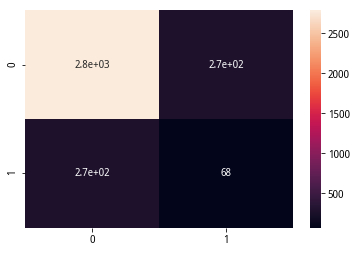

In [82]:
pred_gray_swan = model_outcome(stocks, y, y_hat)

In [ ]:
def clf_model_outcome(stocks, y, y_hat, prob):
    
    return pred_gray_swan

### RNN model
* GRU

In [83]:
train_X, train_y, X, stocks = get_all_data_dl('2019-08-31', '2019-09-30', factors)

002938.XSHE


In [86]:
len(X)

3397

In [84]:
y = get_12mon_yield_rates(stocks, '2019-10-31')

In [87]:
len(y)

3397

In [88]:
def dl_gru(train_X, train_y, X):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, GRU
    model = Sequential()
    model.add(GRU(64, return_sequences=True))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    model.fit(train_X, train_y, epochs=20, validation_split=0.15)
    out = model.predict(X)
    this_mon_out = out[:,-1].flatten()
    return this_mon_out

In [89]:
y_hat = dl_gru()

Train on 2887 samples, validate on 510 samples
Epoch 1/20
2887/2887 [==============================] - 13s 4ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 2/20
2887/2887 [==============================] - 11s 4ms/step - loss: 0.0170 - mean_squared_error: 0.0170 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 3/20
2887/2887 [==============================] - 11s 4ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 4/20
2887/2887 [==============================] - 11s 4ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 5/20
2887/2887 [==============================] - 12s 4ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 6/20
2887/2887 [==============================] - 12s 4ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - val_loss: 0.0

array([0.019552331, -0.055958163, 0.003971832, ..., -0.005317215,
       -0.0027698465, -0.00937362], dtype=float32)

In [ ]:
pred_gray_swan = model_outcome(stocks, y, y_hat)

### Multi-factors Scoring Selection
* Calculate the IC for each factor.
* use IC as the weight, calculate score for factor combination. 
* and select the 50 stocks with the highest scores as the stock pool.

### Single Factor Analysis
* IC & RankIC

In [37]:
factors = [valuation.code,valuation.pb_ratio, valuation.pe_ratio, 
           valuation.market_cap, indicator.inc_net_profit_year_on_year, 
           indicator.inc_net_profit_annual, 
           indicator.inc_total_revenue_year_on_year, 
           indicator.inc_total_revenue_annual]
other_factors = ['DAVOL10','VSTD20','TVSTD20','TVMA20','turnover_volatility',
                 'VOSC','Variance20','sharpe_ratio_20',
                 'Skewness20','Kurtosis20','BIAS10',
                 'arron_up_25','arron_down_25','BBIC','bear_power',
                 'bull_power','CR20','boll_down','boll_up',
                 'EMAC20','MAC20','MACDC','MFI14',
                 'beta','momentum','liquidity','roa_ttm','roe_ttm']

In [31]:
### Single Factor Analysis

#f = ['pe_ratio', 'circulating_cap', 'inc_net_profit_annual']
f= get_all_1_mon_factors(['000001.XSHE'], factors, other_factors, '2016-12-31').columns[1:-1]
d = list(pd.date_range(end='2016-12-31', periods=36, freq='M').strftime('%Y-%m-%d'))

tem_ic = []
tem_rank_ic = []

for j in range(len(d)-1):
    stock_base = get_stock_base(d[j])
    fin_factors = get_all_1_mon_factors(stock_base, factors, other_factors, d[j])
    fin_factors.sort_values(by='code', inplace=True)
    new_yield_r = get_yield_rates(stock_base, d[j+1], d[j])
    new_yield_r.sort_values(by='code', inplace=True)
    tem_ic.append([])
    tem_rank_ic.append([])
    for i in f:
        tem_ic[j].append(fin_factors[i].corr(new_yield_r['yield_rate'], method='pearson'))
        tem_rank_ic[j].append(fin_factors[i].corr(new_yield_r['yield_rate'], method='spearman'))

IC_df = pd.DataFrame(data=tem_ic, index=d[0:-1], columns=f)
RankIC_df = pd.DataFrame(data=tem_rank_ic, index=d[0:-1], columns=f)

In [36]:
IC_df.shape

(35, 35)

##### 1. IC

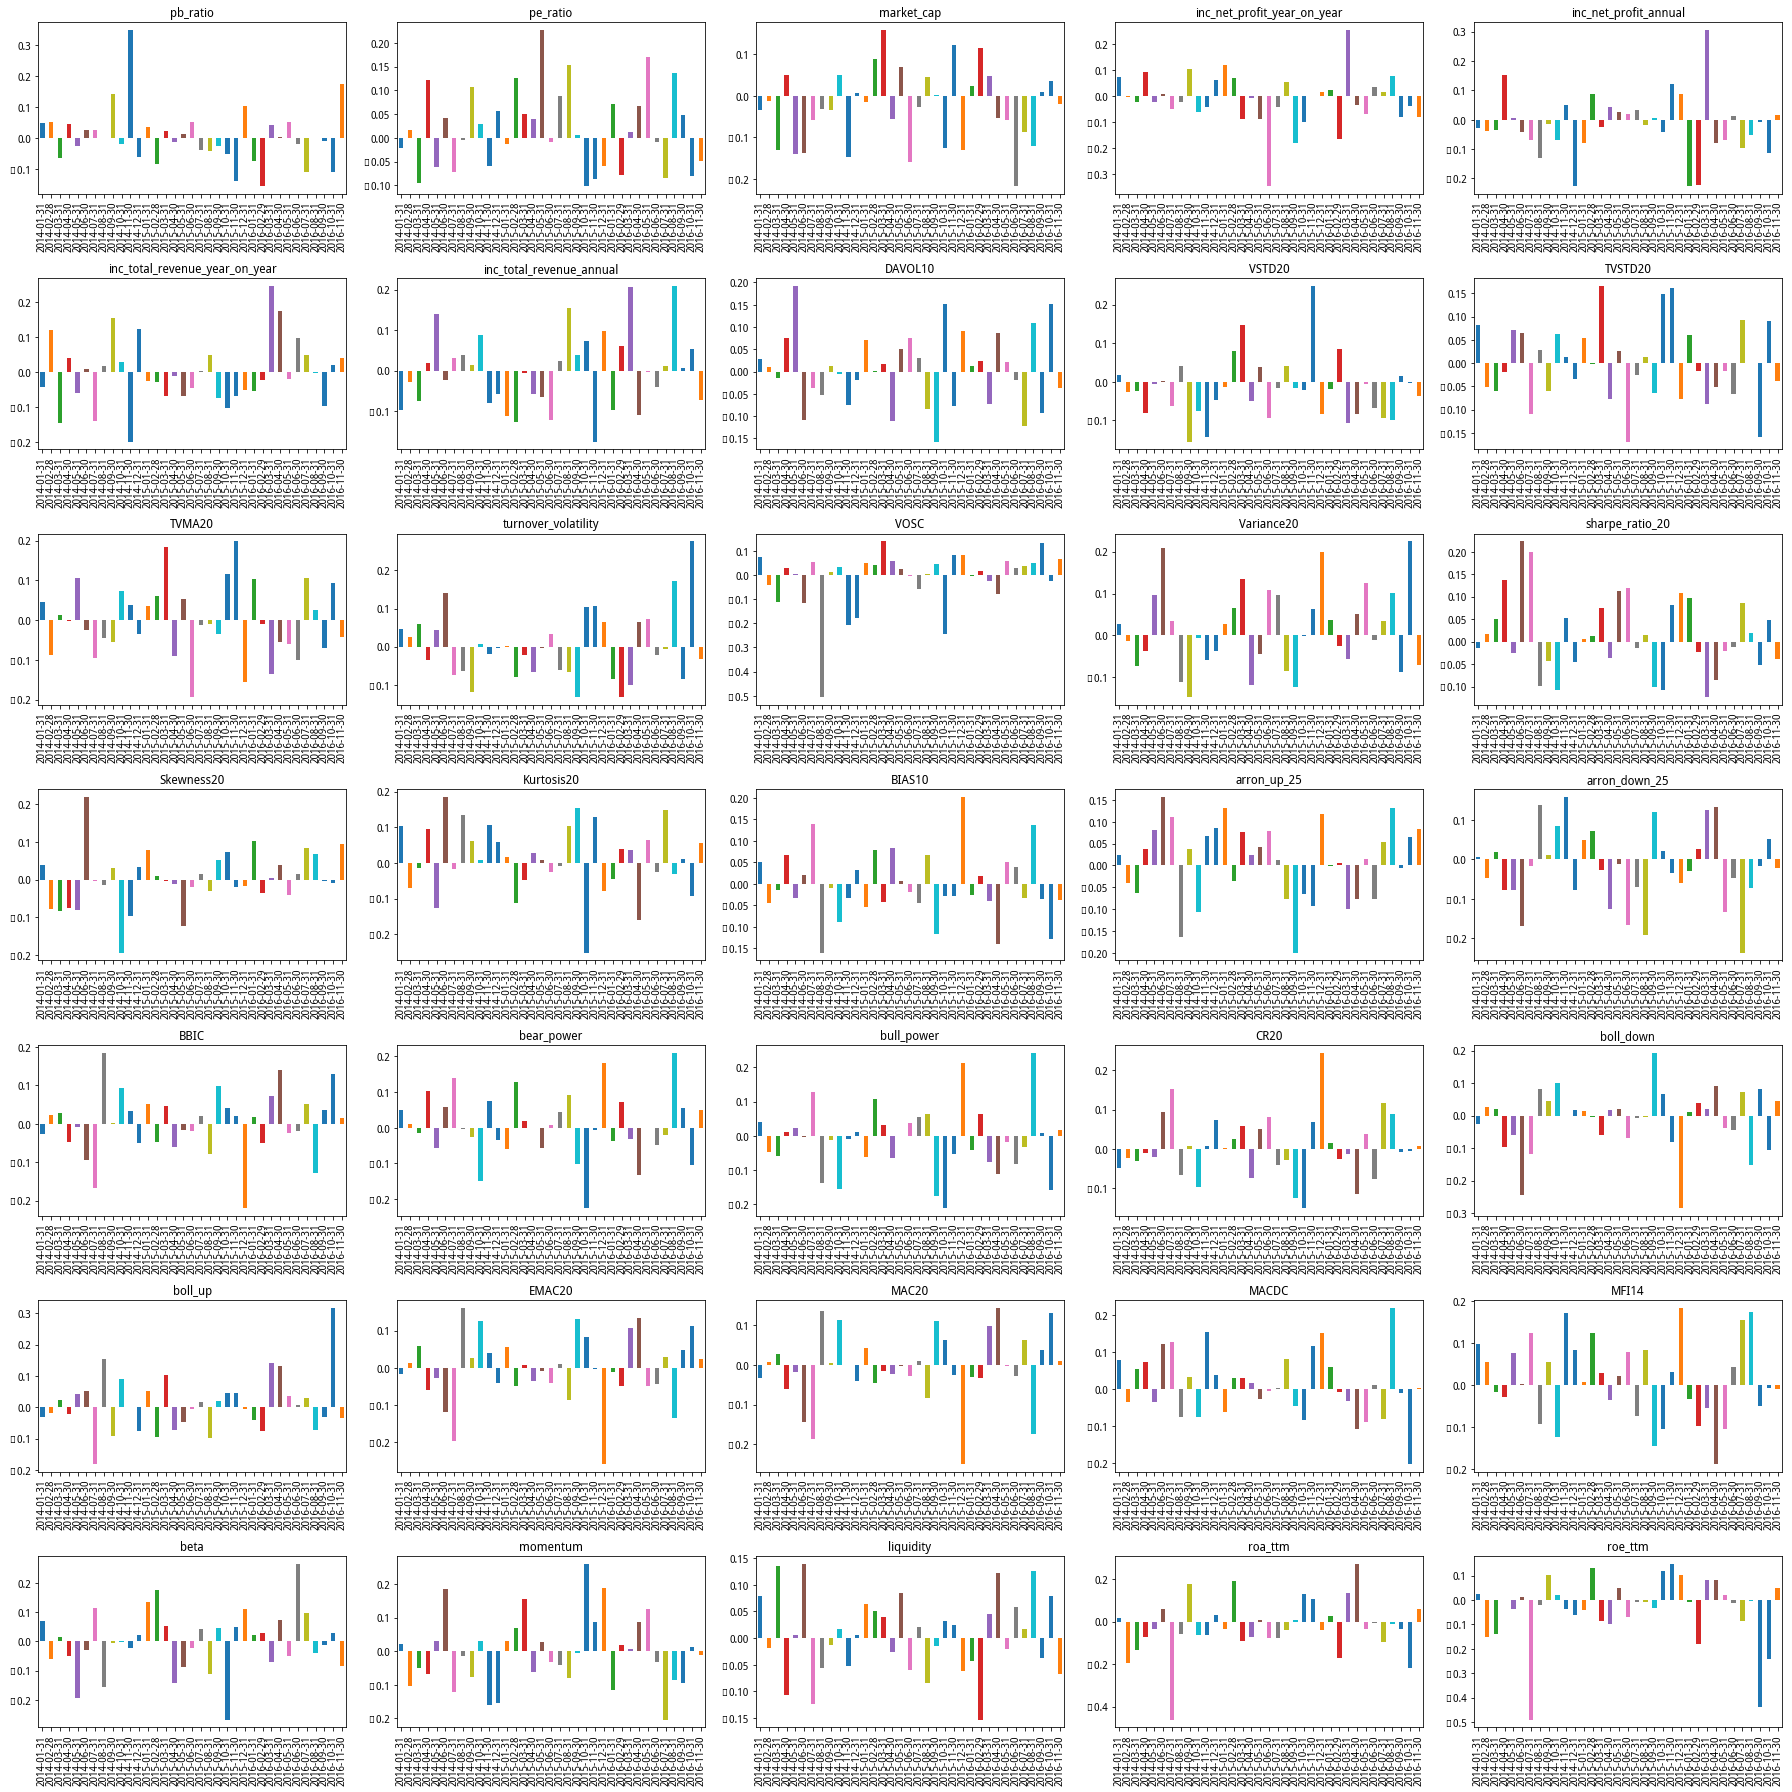

In [34]:
plt.figure(figsize=(25,25))
for i,j in enumerate(f):
    plt.subplot(7,5,i+1)
    IC_df[j].plot.bar()
    plt.title(j)
plt.tight_layout()
#plt.savefig("IC_16.png")

##### 2. RankIC

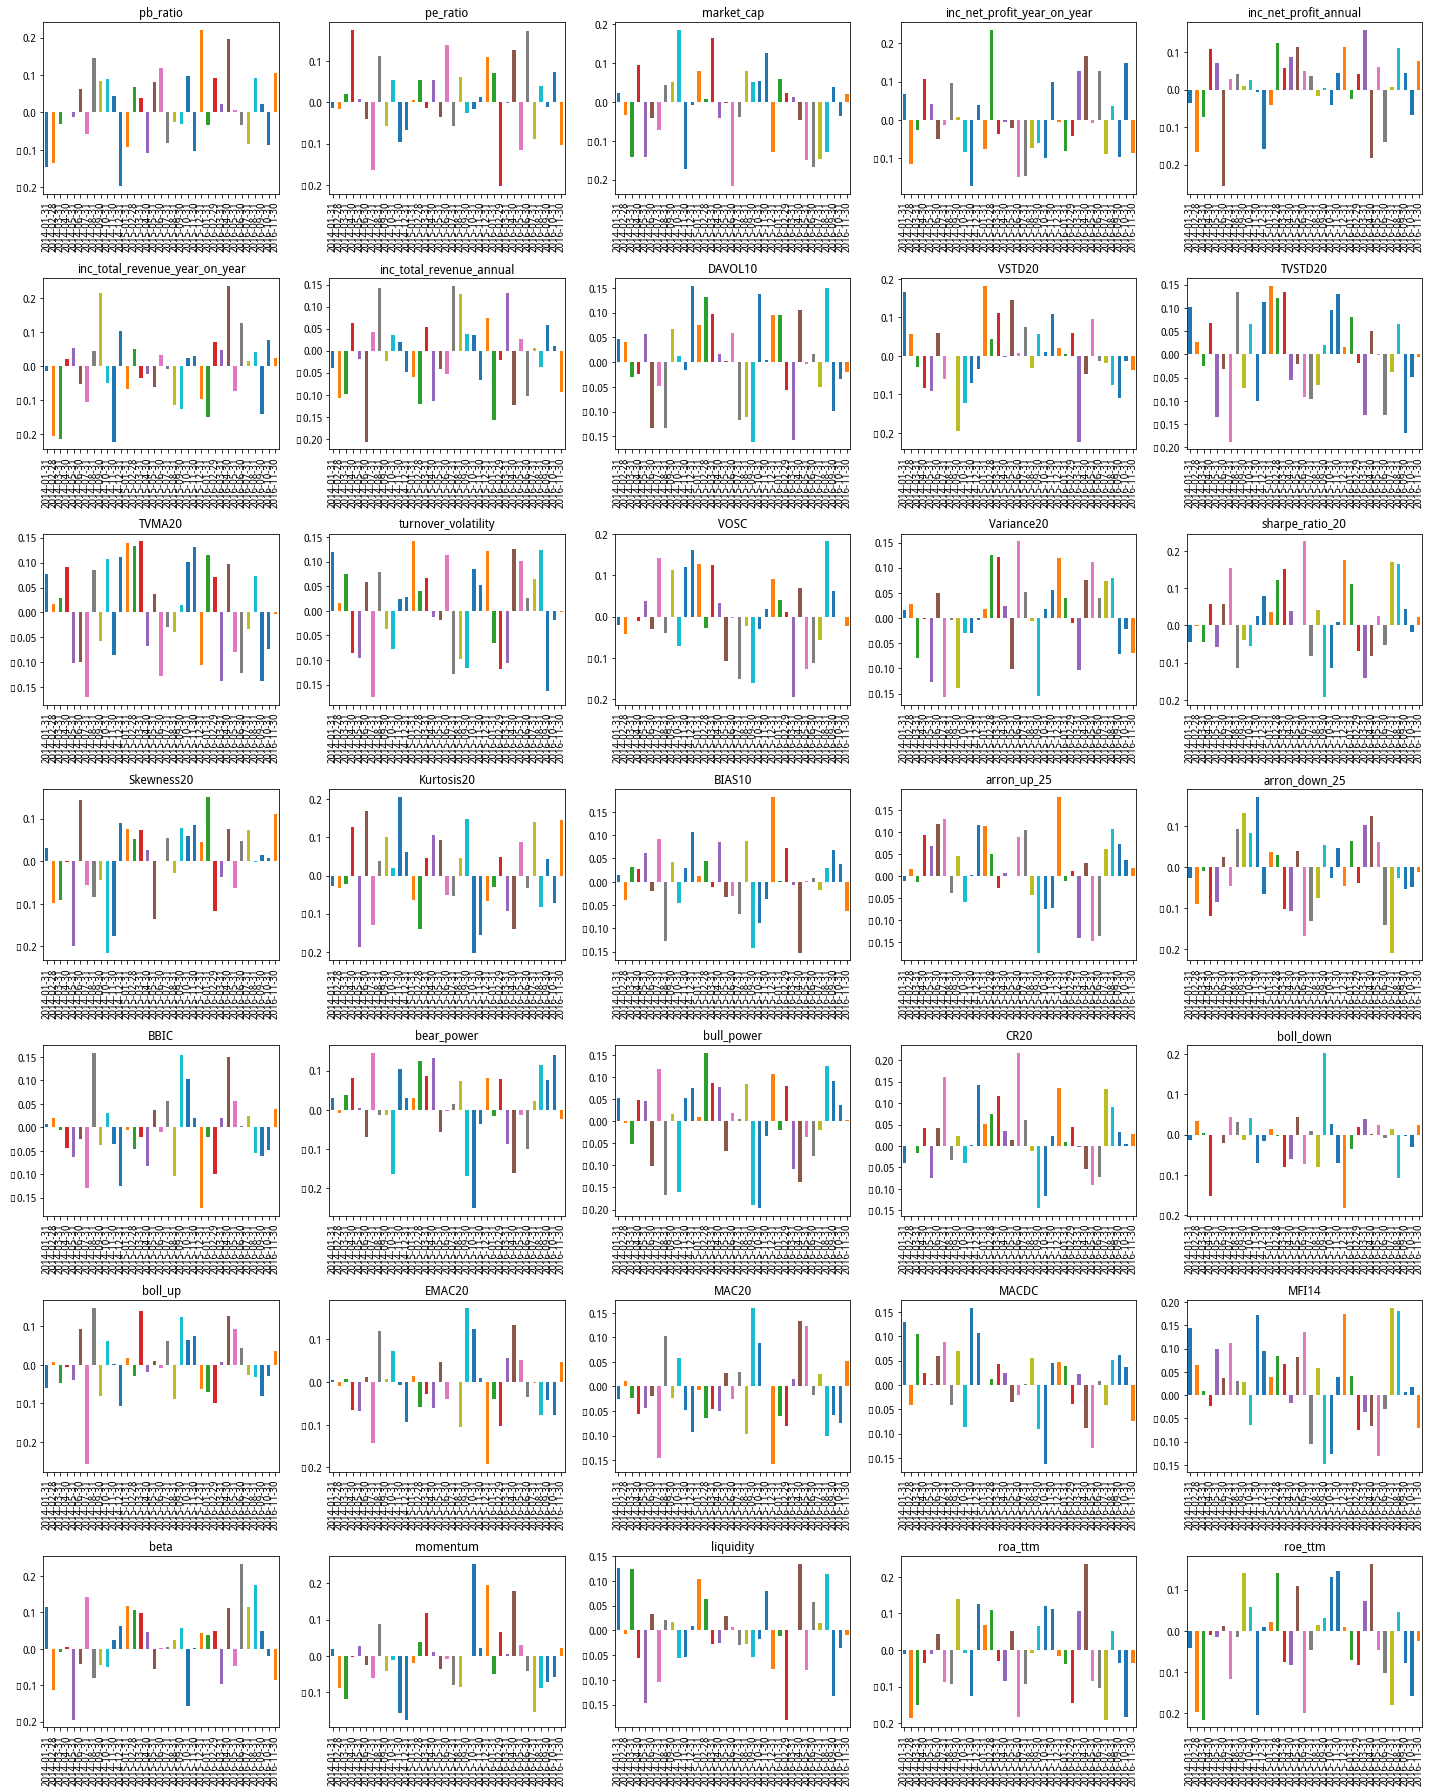

In [35]:
plt.figure(figsize=(20,25))
for i,j in enumerate(f):
    plt.subplot(7,5,i+1)
    RankIC_df[j].plot.bar()
    plt.title(j)
plt.tight_layout()
#plt.savefig("RankIC_16.png")

In [ ]:
##### 3. Factor Correlation Analysis

In [48]:
factors = [valuation.code,valuation.pe_ratio, 
           valuation.market_cap,  
           indicator.inc_net_profit_annual, 
           indicator.inc_total_revenue_annual]
other_factors = ['VSTD20','TVSTD20',
                 'sharpe_ratio_20',
                 'Skewness20','Kurtosis20','BIAS10',
                 'arron_down_25','BBIC',
                 'bull_power','boll_down',
                 'MAC20','MACDC',
                 'beta','roa_ttm','roe_ttm']


In [63]:
s = get_stock_base('2016-12-31')
f= get_all_1_mon_factors(['000001.XSHE'], factors, other_factors, '2016-12-31').columns[1:-1]
mmm = get_all_1_mon_factors(s, factors, other_factors, '2016-12-31')
corr_df = mmm[f].corr(method='pearson')
corr_df

,pe_ratio,market_cap,inc_net_profit_annual,inc_total_revenue_annual,VSTD20,TVSTD20,sharpe_ratio_20,Skewness20,Kurtosis20,BIAS10,arron_down_25,BBIC,bull_power,boll_down,MAC20,MACDC,beta,roa_ttm,roe_ttm
pe_ratio,1.000000,-0.001997,0.001424,-0.000935,-0.003824,0.001104,-0.002784,-0.002598,-0.001323,-0.010733,0.011802,0.016608,-0.015715,-0.008420,0.016418,0.004289,0.040093,-0.003129,-0.000372
market_cap,-0.001997,1.000000,-0.001919,-0.004841,0.401677,0.286268,-0.004369,0.060853,-0.071498,0.005705,0.062882,0.001138,-0.028690,0.063686,0.017002,-0.064284,-0.248859,0.019258,-0.002036
inc_net_profit_annual,0.001424,-0.001919,1.000000,-0.000489,-0.002701,0.001477,-0.001360,-0.019130,0.015741,-0.005392,-0.001919,0.005127,0.003791,0.004954,0.005189,-0.006365,-0.013345,0.006664,-0.000306
inc_total_revenue_annual,-0.000935,-0.004841,-0.000489,1.000000,-0.004199,-0.007584,-0.000654,0.018886,-0.039745,0.008086,-0.027731,-0.011328,0.010370,-0.000039,-0.009946,-0.005713,-0.023216,-0.013461,-0.019426
VSTD20,-0.003824,0.401677,-0.002701,-0.004199,1.000000,0.644031,-0.001397,0.126320,-0.084469,-0.021175,-0.020859,0.016008,0.051094,-0.061562,-0.011292,-0.077829,-0.120764,-0.068976,-0.002104
TVSTD20,0.001104,0.286268,0.001477,-0.007584,0.644031,1.000000,0.002804,0.245515,-0.162443,-0.083917,-0.089495,0.061916,0.106655,-0.213564,0.007633,-0.179276,-0.165726,-0.043358,-0.004877
sharpe_ratio_20,-0.002784,-0.004369,-0.001360,-0.000654,-0.001397,0.002804,1.000000,0.024200,-0.038460,0.315738,-0.007355,-0.224367,0.185203,-0.270462,-0.212037,0.169706,-0.019161,-0.019939,-0.000930
Skewness20,-0.002598,0.060853,-0.019130,0.018886,0.126320,0.245515,0.024200,1.000000,-0.612418,0.087243,-0.277515,-0.193557,0.217324,-0.234525,-0.252178,-0.042410,-0.371951,-0.027647,0.021441
Kurtosis20,-0.001323,-0.071498,0.015741,-0.039745,-0.084469,-0.162443,-0.038460,-0.612418,1.000000,-0.011492,0.161447,0.088232,-0.121313,0.111928,0.127414,0.100043,0.328825,0.010570,-0.004099
BIAS10,-0.010733,0.005705,-0.005392,0.008086,-0.021175,-0.083917,0.315738,0.087243,-0.011492,1.000000,-0.223502,-0.944874,0.733399,-0.613058,-0.846644,0.728623,-0.054689,-0.022242,-0.014868


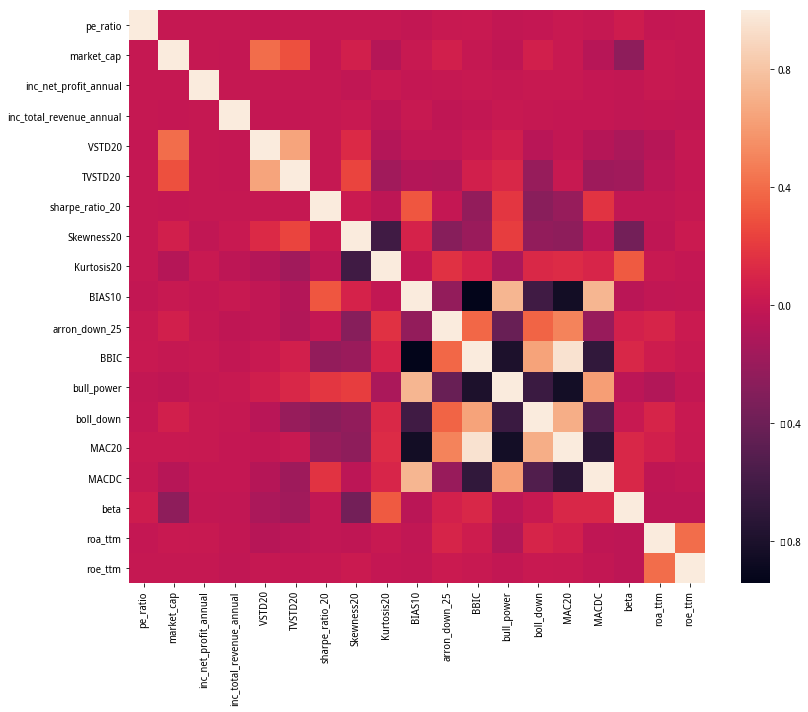

In [64]:
import seaborn as sns
plt.subplots(figsize=(12,10))
sns.heatmap(corr_df)
plt.tight_layout()
#plt.savefig("Corr_17.png")